In [2]:
!pip install segmentation_models_pytorch albumentations==1.3.0 --quiet


import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


Torch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4


In [3]:
import kagglehub


path = kagglehub.dataset_download("dschettler8845/brats-2021-task1")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/brats-2021-task1


In [4]:
import os


for f in os.listdir(path):
    print(f)

BraTS2021_00495.tar
BraTS2021_Training_Data.tar
BraTS2021_00621.tar


In [5]:
import os
import tarfile
base_path = "/root/.cache/kagglehub/datasets/dschettler8845/brats-2021-task1/versions/1"
extract_path = "/root/.cache/kagglehub/datasets/dschettler8845/brats-2021-task1/extracted"
os.makedirs(extract_path, exist_ok=True)

for filename in os.listdir(base_path):
    if filename.endswith(".tar"):
        file_path = os.path.join(base_path, filename)
        print(f"Extracting {filename}...")
        with tarfile.open(file_path) as tar:
            tar.extractall(path=extract_path)

print("All archives extracted.")
print("Folders extracted:", os.listdir(extract_path)[:5])


Extracting BraTS2021_00495.tar...
Extracting BraTS2021_Training_Data.tar...
Extracting BraTS2021_00621.tar...
All archives extracted.
Folders extracted: ['BraTS2021_01082', 'BraTS2021_01083', 'BraTS2021_00132', 'BraTS2021_01533', 'BraTS2021_01058']


In [6]:
extract_path = '/root/.cache/kagglehub/datasets/dschettler8845/brats-2021-task1/extracted'
folders = sorted(os.listdir(extract_path))
print(folders)


['.DS_Store', 'BraTS2021_00000', 'BraTS2021_00002', 'BraTS2021_00003', 'BraTS2021_00005', 'BraTS2021_00006', 'BraTS2021_00008', 'BraTS2021_00009', 'BraTS2021_00011', 'BraTS2021_00012', 'BraTS2021_00014', 'BraTS2021_00016', 'BraTS2021_00017', 'BraTS2021_00018', 'BraTS2021_00019', 'BraTS2021_00020', 'BraTS2021_00021', 'BraTS2021_00022', 'BraTS2021_00024', 'BraTS2021_00025', 'BraTS2021_00026', 'BraTS2021_00028', 'BraTS2021_00030', 'BraTS2021_00031', 'BraTS2021_00032', 'BraTS2021_00033', 'BraTS2021_00035', 'BraTS2021_00036', 'BraTS2021_00043', 'BraTS2021_00044', 'BraTS2021_00045', 'BraTS2021_00046', 'BraTS2021_00048', 'BraTS2021_00049', 'BraTS2021_00051', 'BraTS2021_00052', 'BraTS2021_00053', 'BraTS2021_00054', 'BraTS2021_00056', 'BraTS2021_00058', 'BraTS2021_00059', 'BraTS2021_00060', 'BraTS2021_00061', 'BraTS2021_00062', 'BraTS2021_00063', 'BraTS2021_00064', 'BraTS2021_00066', 'BraTS2021_00068', 'BraTS2021_00070', 'BraTS2021_00071', 'BraTS2021_00072', 'BraTS2021_00074', 'BraTS2021_00077'

In [7]:
import os

all_patients = sorted(os.listdir(extract_path))
selected_patients = all_patients[:200]

print(f"Selected {len(selected_patients)} patients")



Selected 200 patients


In [8]:
folders = sorted([
    f for f in os.listdir(extract_path)
    if os.path.isdir(os.path.join(extract_path, f))
])

first_patient = os.path.join(extract_path, folders[0])
print("Files in first patient folder:", os.listdir(first_patient))


Files in first patient folder: ['BraTS2021_00000_t1.nii.gz', 'BraTS2021_00000_t2.nii.gz', 'BraTS2021_00000_flair.nii.gz', 'BraTS2021_00000_seg.nii.gz', 'BraTS2021_00000_t1ce.nii.gz']


In [9]:
image_paths = []
mask_paths = []

for patient in selected_patients:
    image_path = os.path.join(extract_path, patient, f"{patient}_flair.nii.gz")
    mask_path = os.path.join(extract_path, patient, f"{patient}_seg.nii.gz")
    if os.path.exists(image_path) and os.path.exists(mask_path):
        image_paths.append(image_path)
        mask_paths.append(mask_path)


In [10]:
from torch.utils.data import Dataset
from skimage.transform import resize
import nibabel as nib
import torch
import numpy as np
import albumentations as A

class BraTSDataset(Dataset):
    def __init__(self, image_paths, mask_paths, is_train=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.is_train = is_train

        if self.is_train:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            ])
        else:
            self.transform = None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = nib.load(self.image_paths[idx]).get_fdata()
        mask = nib.load(self.mask_paths[idx]).get_fdata()

        slice_index = image.shape[2] // 2
        image_slice = image[:, :, slice_index]
        mask_slice = mask[:, :, slice_index]

        mask_slice = (mask_slice > 0).astype(np.float32)

        image_resized = resize(image_slice, (128, 128), preserve_range=True, mode='constant')
        mask_resized  = resize(mask_slice,  (128, 128), preserve_range=True, mode='constant', order=0)
        mask_resized  = (mask_resized > 0.5).astype(np.float32)

        image_resized = (image_resized - image_resized.min()) / (image_resized.max() - image_resized.min() + 1e-8)


        image_np = image_resized.astype(np.float32)[..., np.newaxis]
        mask_np  = mask_resized.astype(np.float32)[..., np.newaxis]

        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image_np, mask_np = augmented['image'], augmented['mask']


        image_tensor = torch.tensor(image_np).permute(2, 0, 1)
        mask_tensor  = torch.tensor(mask_np).permute(2, 0, 1)

        return image_tensor, mask_tensor


In [11]:
from torch.utils.data import DataLoader

split = int(0.9 * 200)

train_dataset = BraTSDataset(image_paths[:split], mask_paths[:split])
test_dataset  = BraTSDataset(image_paths[split:200], mask_paths[split:200])

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False
)

for x, y in train_loader:
    print("Image batch:", x.shape)
    print("Mask batch:", y.shape)
    break


Image batch: torch.Size([8, 1, 128, 128])
Mask batch: torch.Size([8, 1, 128, 128])


In [12]:
import torch
import segmentation_models_pytorch as smp


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
)

model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [13]:
import torch
from torch.amp import autocast, GradScaler

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = GradScaler()

def train(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, masks.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")
        if (epoch + 1) % 10 == 0:
            checkpoint_name = f"unetpp_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), checkpoint_name)
            print(f"Saved checkpoint: {checkpoint_name}")


In [14]:
for img, mask in train_loader:
    print("Image - min:", img.min().item(), "max:", img.max().item(), "mean:", img.mean().item())
    print("Mask - unique values:", torch.unique(mask))
    break




Image - min: 0.0 max: 1.0 mean: 0.10998942703008652
Mask - unique values: tensor([0., 1.])


In [15]:
train(model, train_loader, epochs=100)



Epoch 1/100 | Loss: 13.1382
Epoch 2/100 | Loss: 9.7053
Epoch 3/100 | Loss: 7.6881
Epoch 4/100 | Loss: 6.3357
Epoch 5/100 | Loss: 5.4783
Epoch 6/100 | Loss: 4.9508
Epoch 7/100 | Loss: 4.5672
Epoch 8/100 | Loss: 4.1551
Epoch 9/100 | Loss: 3.9262
Epoch 10/100 | Loss: 3.6379
Saved checkpoint: unetpp_epoch10.pth
Epoch 11/100 | Loss: 3.5019
Epoch 12/100 | Loss: 3.2106
Epoch 13/100 | Loss: 2.9920
Epoch 14/100 | Loss: 2.7886
Epoch 15/100 | Loss: 2.6207
Epoch 16/100 | Loss: 2.4520
Epoch 17/100 | Loss: 2.3453
Epoch 18/100 | Loss: 2.2156
Epoch 19/100 | Loss: 2.0821
Epoch 20/100 | Loss: 1.9781
Saved checkpoint: unetpp_epoch20.pth
Epoch 21/100 | Loss: 1.8853
Epoch 22/100 | Loss: 1.7745
Epoch 23/100 | Loss: 1.6962
Epoch 24/100 | Loss: 1.6428
Epoch 25/100 | Loss: 1.5381
Epoch 26/100 | Loss: 1.4741
Epoch 27/100 | Loss: 1.4189
Epoch 28/100 | Loss: 1.3710
Epoch 29/100 | Loss: 1.3121
Epoch 30/100 | Loss: 1.3138
Saved checkpoint: unetpp_epoch30.pth
Epoch 31/100 | Loss: 1.2304
Epoch 32/100 | Loss: 1.1702
E

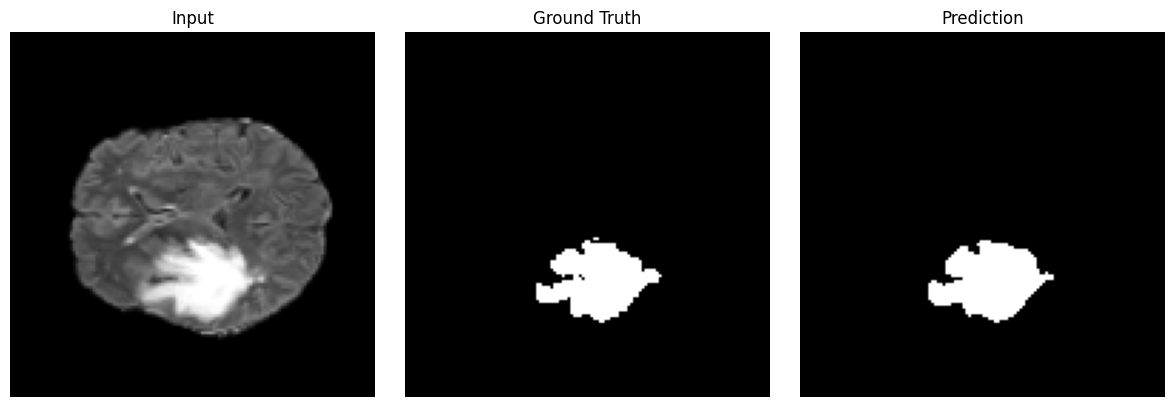

In [16]:
import matplotlib.pyplot as plt

model.eval()
shown = 0
num_images = 3

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        for i in range(images.size(0)):
            if shown >= num_images:
                break

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(images[i, 0].cpu(), cmap='gray')
            axes[0].set_title("Input")
            axes[1].imshow(masks[i, 0].cpu(), cmap='gray')
            axes[1].set_title("Ground Truth")
            axes[2].imshow(preds[i, 0].cpu(), cmap='gray')
            axes[2].set_title("Prediction")

            for ax in axes:
                ax.axis('off')

            plt.tight_layout()
            plt.show()

            shown += 1

        if shown >= num_images:
            break


In [17]:
def dice_coef(pred, target, smooth=1e-5):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1e-5):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)


In [18]:
model.eval()
dice_scores = []
iou_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        for pred, mask in zip(preds, masks):
            dice = dice_coef(pred, mask)
            iou = iou_score(pred, mask)
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

avg_dice = sum(dice_scores) / len(dice_scores)
avg_iou = sum(iou_scores) / len(iou_scores)

print(f"Average Dice Coefficient: {avg_dice:.4f}")
print(f"Average IoU Score: {avg_iou:.4f}")

Average Dice Coefficient: 0.8230
Average IoU Score: 0.7491


In [21]:
from google.colab import files
files.download('unet_brats.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>